# Introduction
FLO Retail and Marketing Inc. is selling shoes both online and offline. In this project we are going to segment its customer then adress these customers according to companies' needs. Also we are going to calculate CLV for customers by using BG-NBD and Gamma Gamma models.

![](https://d35fo82fjcw0y8.cloudfront.net/2018/03/01013239/Header-e1551869702205.png)

# Business Cases:
## Business Case 1:
### FLO aims to segment its customers and determine marketing strategies based on these segments. To achieve this, customer behavior will be defined, and groups will be formed based on behavior clustering.
## Business Case 2:
### FLO intends to establish a roadmap for sales and marketing activities. To enable the company to plan for the medium to long-term, it is necessary to estimate the potential value that existing customers will provide to the company in the future.

# Dataset Story

The dataset consists of information derived from the past shopping behavior of customers who made their purchases in the years 2020-2021.

* master_id: Unique Customer Number
* order_channel : Which channel to be used for shopping (Android, ios, Desktop, Mobile, Offline)
* last_order_channel : Last channel to be used for order
* first_order_date : First purchase date of the customer
* last_order_date : Last purchase date of the customer
* last_order_date_online : Last purchase date of the customer online
* last_order_date_offline : Last purchase date of the customer offline
* order_num_total_ever_online : Total number of purchases that are made online
* order_num_total_ever_offline : Total number of purchases that are made offline
* customer_value_total_ever_offline : Total amount paid by the customer in offline purchases
* customer_value_total_ever_online : Total amount paid by the customer in online purchases
* interested_in_categories_12 : The list of categories in which the customer has shopped in the last 12 months

# Importing necessary libraries and settings

In [1]:
!pip install lifetimes

import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import squarify
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option("display.width", 1000)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.3 MB/s eta 0:00:00
/kaggle/input/flo-data-miuul/flo_data_20k.csv


# Loading and Understanding Data

In [2]:
df_ = pd.read_csv("/kaggle/input/flo-data-miuul/flo_data_20k.csv")
df = df_.copy()

def check_df(dataframe):
    print("##################### First 10 Observations #####################")
    print(dataframe.head(10))
    print("##################### Column names #####################")
    print(df.info())
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Types #####################")
    print(dataframe.dtypes)
check_df(df)

##################### First 10 Observations #####################
                              master_id order_channel last_order_channel first_order_date last_order_date last_order_date_online last_order_date_offline  order_num_total_ever_online  order_num_total_ever_offline  customer_value_total_ever_offline  customer_value_total_ever_online       interested_in_categories_12
0  cc294636-19f0-11eb-8d74-000d3a38a36f   Android App            Offline       2020-10-30      2021-02-26             2021-02-21              2021-02-26                        4.000                         1.000                            139.990                           799.380                           [KADIN]
1  f431bd5a-ab7b-11e9-a2fc-000d3a38a36f   Android App             Mobile       2017-02-08      2021-02-16             2021-02-16              2020-01-10                       19.000                         2.000                            159.970                          1853.580  [ERKEK, COCUK, KADIN, 

We have to find the total amount paid and the total number of order for each unique customer. To calculate the total value generated by a customer we sum the amounts paid both in online and offline. To calculate the total number of order, we sum offline and online orders.

In [3]:
df["total_customer_value"]=df["customer_value_total_ever_offline"]+df["customer_value_total_ever_online"]

df["total_num_order"] = df["order_num_total_ever_online"]+df["order_num_total_ever_offline"]

df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,total_customer_value,total_num_order
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.000,1.000,139.990,799.380,[KADIN],939.370,5.000
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.000,2.000,159.970,1853.580,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",2013.550,21.000
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.000,2.000,189.970,395.350,"[ERKEK, KADIN]",585.320,5.000
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.000,1.000,39.990,81.980,"[AKTIFCOCUK, COCUK]",121.970,2.000
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.000,1.000,49.990,159.990,[AKTIFSPOR],209.980,2.000


We have to convert variables that contains date values to date variables by using pd.to_datetime method

In [4]:
for i in df.columns:
    if "date" in i:
        print(i)
        df[i] = df[i].apply(pd.to_datetime)
        print(df[i].dtype)

first_order_date
datetime64[ns]
last_order_date
datetime64[ns]
last_order_date_online
datetime64[ns]
last_order_date_offline
datetime64[ns]


Pre processing function for the things that we made above to prepare the dataset for analyzing

In [5]:
def pre_processing(df):
    for i in df.columns:
        if "date" in i:
            df[i] = df[i].apply(pd.to_datetime)
    df["total_num_order"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]
    df["total_customer_value"] = df["customer_value_total_ever_offline"] + df["customer_value_total_ever_online"]
    check_df(df)

Let's examine the distribution of the number of customers, the total number of products purchased and the total amount paid by the customers across shopping channels.

In [6]:
df.groupby("order_channel").agg({"master_id": ["count"],
                                 "total_num_order":["sum"],
                                "total_customer_value":["sum"]})

,master_id,total_num_order,total_customer_value
,count,sum,sum
order_channel,,,
Android App,9495,52269.000,7819062.760
Desktop,2735,10920.000,1610321.460
Ios App,2833,15351.000,2525999.930
Mobile,4882,21679.000,3028183.160


First ten customer with highest revenue

In [7]:
df.sort_values("total_customer_value",ascending=False).iloc[0:10,[0,12]]

,master_id,total_customer_value
11150,5d1c466a-9cfd-11e9-9897-000d3a38a36f,45905.100
4315,d5ef8058-a5c6-11e9-a2fc-000d3a38a36f,36818.290
7613,73fd19aa-9e37-11e9-9897-000d3a38a36f,33918.100
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,31227.410
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,20706.340
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,18443.570
8068,d696c654-2633-11ea-8e1c-000d3a38a36f,16918.570
163,fef57ffa-aae6-11e9-a2fc-000d3a38a36f,12726.100
7223,cba59206-9dd1-11e9-9897-000d3a38a36f,12282.240
18767,fc0ce7a4-9d87-11e9-9897-000d3a38a36f,12103.150


First ten customer with highest number of orders

In [8]:
df.sort_values("total_num_order",ascending=False).iloc[0:10,[0,13]]

,master_id,total_num_order
11150,5d1c466a-9cfd-11e9-9897-000d3a38a36f,202.000
7223,cba59206-9dd1-11e9-9897-000d3a38a36f,131.000
8783,a57f4302-b1a8-11e9-89fa-000d3a38a36f,111.000
2619,fdbe8304-a7ab-11e9-a2fc-000d3a38a36f,88.000
6322,329968c6-a0e2-11e9-a2fc-000d3a38a36f,83.000
7613,73fd19aa-9e37-11e9-9897-000d3a38a36f,82.000
9347,44d032ee-a0d4-11e9-a2fc-000d3a38a36f,77.000
10954,b27e241a-a901-11e9-a2fc-000d3a38a36f,75.000
8068,d696c654-2633-11ea-8e1c-000d3a38a36f,70.000
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,70.000


# Calculating RFM Metrics

To calculate our recency metrics, we have to determine a current date. Let's assume that, this analysis is being conducted 2 days after the latest purchases made in the whole dateset.

In [9]:
df["last_order_date"].max() #'2021-05-30'
today_date = dt.datetime(2021, 6, 1)

In [10]:
df["days_last_seen"]=df["last_order_date"].apply(lambda x: (today_date-x).days)
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,total_customer_value,total_num_order,days_last_seen
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.000,1.000,139.990,799.380,[KADIN],939.370,5.000,95
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.000,2.000,159.970,1853.580,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",2013.550,21.000,105
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.000,2.000,189.970,395.350,"[ERKEK, KADIN]",585.320,5.000,186
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.000,1.000,39.990,81.980,"[AKTIFCOCUK, COCUK]",121.970,2.000,135
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.000,1.000,49.990,159.990,[AKTIFSPOR],209.980,2.000,86


## RFM metrics:
* Recency: df["days_last_seen"]
* Frequency: df["total_num_order"]
* Monetary: df["total_customer_value"]

In [11]:
rfm = df.loc[:,["master_id", "days_last_seen", "total_num_order", "total_customer_value"]]
rfm.columns = ["customer_id", "recency", "frequency", "monetary"]
rfm.head()

,customer_id,recency,frequency,monetary
0,cc294636-19f0-11eb-8d74-000d3a38a36f,95,5.000,939.370
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,105,21.000,2013.550
2,69b69676-1a40-11ea-941b-000d3a38a36f,186,5.000,585.320
3,1854e56c-491f-11eb-806e-000d3a38a36f,135,2.000,121.970
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,86,2.000,209.980


In [12]:
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,19945.000,134.458,103.281,2.000,43.000,111.000,202.000,367.000
frequency,19945.000,5.025,4.743,2.000,3.000,4.000,6.000,202.000
monetary,19945.000,751.244,895.402,44.980,339.980,545.270,897.780,45905.100


## Calculating RF Scores
We have to standardize rfm metrics, therefore by using qcut method, we convert different rfm values to scores from 1-5

In [13]:
rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])

rfm["frequency_score"] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])
rfm.head()

,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score
0,cc294636-19f0-11eb-8d74-000d3a38a36f,95,5.000,939.370,3,4,4
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,105,21.000,2013.550,3,5,5
2,69b69676-1a40-11ea-941b-000d3a38a36f,186,5.000,585.320,2,4,3
3,1854e56c-491f-11eb-806e-000d3a38a36f,135,2.000,121.970,3,1,1
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,86,2.000,209.980,3,1,1


Monetary_score is not included in calculation, because if a customer frequently makes purchases this means he/she will grant revenue. The method below grant us a combined score which will be used to segment our customers according their status

In [14]:
rfm["RF_SCORE"] = (rfm['recency_score'].astype(str) +
                    rfm['frequency_score'].astype(str))

rfm.head()

,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RF_SCORE
0,cc294636-19f0-11eb-8d74-000d3a38a36f,95,5.000,939.370,3,4,4,34
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,105,21.000,2013.550,3,5,5,35
2,69b69676-1a40-11ea-941b-000d3a38a36f,186,5.000,585.320,2,4,3,24
3,1854e56c-491f-11eb-806e-000d3a38a36f,135,2.000,121.970,3,1,1,31
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,86,2.000,209.980,3,1,1,31


In [15]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}
rfm['segment'] = rfm['RF_SCORE'].replace(seg_map, regex=True)
rfm.head()

,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RF_SCORE,segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,95,5.000,939.370,3,4,4,34,loyal_customers
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,105,21.000,2013.550,3,5,5,35,loyal_customers
2,69b69676-1a40-11ea-941b-000d3a38a36f,186,5.000,585.320,2,4,3,24,at_Risk
3,1854e56c-491f-11eb-806e-000d3a38a36f,135,2.000,121.970,3,1,1,31,about_to_sleep
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,86,2.000,209.980,3,1,1,31,about_to_sleep


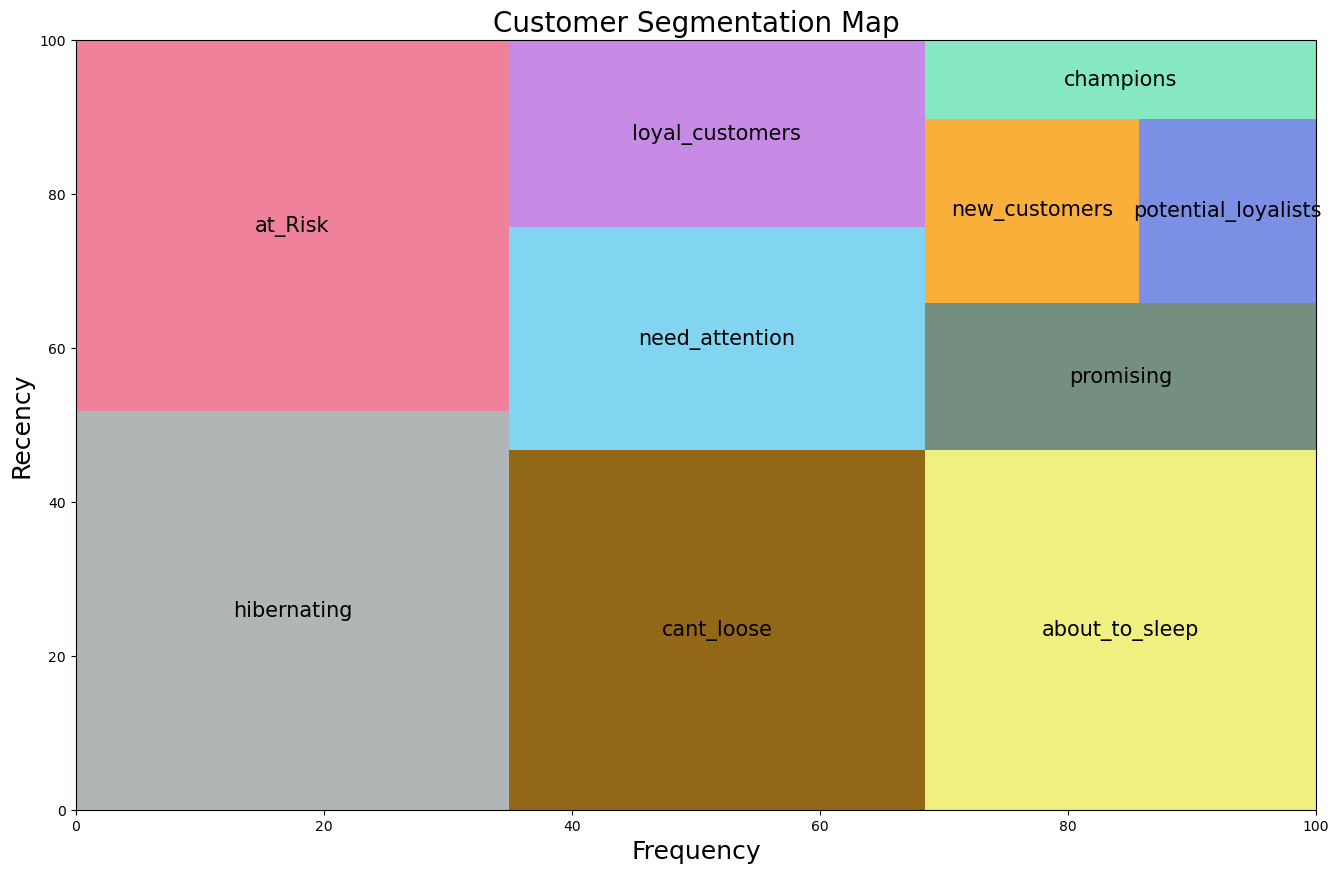

In [16]:
segments = rfm["segment"].value_counts().sort_values(ascending=False)
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 10)
squarify.plot(
    sizes=segments,
    label=[label for label in seg_map.values()],
    color=[
        "#AFB6B5",
        "#F0819A",
        "#926717",
        "#F0F081",
        "#81D5F0",
        "#C78BE5",
        "#748E80",
        "#FAAF3A",
        "#7B8FE4",
        "#86E8C0",
    ],
    pad=False,
    bar_kwargs={"alpha": 1},
    text_kwargs={"fontsize": 15},
)
plt.title("Customer Segmentation Map", fontsize=20)
plt.xlabel("Frequency", fontsize=18)
plt.ylabel("Recency", fontsize=18)
plt.show()

In [17]:
rfm[["segment", "recency", "frequency", "monetary"]].groupby("segment").agg(["mean", "count"])

recency       frequency       monetary      
                       mean count      mean count     mean count
segment                                                         
about_to_sleep      113.785  1629     2.401  1629  359.009  1629
at_Risk             241.607  3131     4.472  3131  646.610  3131
cant_loose          235.444  1200    10.698  1200 1474.468  1200
champions            17.107  1932     8.934  1932 1406.625  1932
hibernating         247.950  3604     2.394  3604  366.267  3604
loyal_customers      82.595  3361     8.375  3361 1216.819  3361
need_attention      113.829   823     3.728   823  562.143   823
new_customers        17.918   680     2.000   680  339.956   680
potential_loyalists  37.156  2938     3.304  2938  533.184  2938
promising            58.921   647     2.000   647  335.673   647

### Case 1.a) FLO is adding a new women's shoe brand to its portfolio. The prices of the products of this new brand are above the general customer preferences. Therefore, it is desired to reach out to customers who match the interested profile to promote the brand and its products. It is planned that these customers should be loyal and purchase in female category.

In [18]:
rfm.rename(columns={"customer_id":"master_id"}, inplace=True)
rfm_new = pd.merge(rfm, df, on="master_id")
selected_ones = rfm_new.loc[
    ((rfm_new["segment"] == "loyal_customers") | (rfm_new["segment"] == "champions") &
     rfm_new["interested_in_categories_12"].str.contains("KADIN")),
    ["master_id", "interested_in_categories_12", "segment"]
]
selected_ones.head()

,master_id,interested_in_categories_12,segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,[KADIN],loyal_customers
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",loyal_customers
8,cfbda69e-5b4f-11ea-aca7-000d3a38a36f,"[ERKEK, COCUK, KADIN]",loyal_customers
11,c2e15af2-9eed-11e9-9897-000d3a38a36f,"[COCUK, KADIN, AKTIFSPOR]",champions
30,1618f596-130a-11ea-a001-000d3a38a36f,[AKTIFSPOR],loyal_customers


### Case 2.a) A discount of nearly 40% is planned for Men's and Children's products. The aim is to target customers who are interested in these discounted categories, including past high-value customers who haven't shopped for a long time and new customers."

In [19]:
selected_ones_2 = rfm_new.loc[
    ((rfm_new["segment"] == "new_customers") | (rfm_new["segment"] == "cant_loose") | (rfm_new["segment"] == "at_Risk"))
    & ((rfm_new["interested_in_categories_12"].str.contains("COCUK")) |
       (rfm_new["interested_in_categories_12"].str.contains("ERKEK"))),
    ["master_id", "interested_in_categories_12","segment"]
]
                                 
selected_ones_2.head()

,master_id,interested_in_categories_12,segment
2,69b69676-1a40-11ea-941b-000d3a38a36f,"[ERKEK, KADIN]",at_Risk
15,13ed97a4-b167-11e9-89fa-000d3a38a36f,"[AKTIFCOCUK, COCUK, KADIN]",cant_loose
16,d9b77226-a509-11e9-a2fc-000d3a38a36f,[COCUK],at_Risk
39,280cd78c-f324-11e9-9346-000d3a38a36f,"[ERKEK, AKTIFSPOR]",at_Risk
67,9e060288-2eed-11ea-8467-000d3a38a36f,"[AKTIFCOCUK, ERKEK, COCUK]",at_Risk


In [20]:
selected_ones.to_csv("customers_for_new_brand.csv")
selected_ones_2.to_csv("customers_for_discount.csv")
# os.remove("/kaggle/working/x.csv") # New explore, you'll use this when you want to delete an output in kaggle notebook

# Calculating CLV

In [21]:
df2 = df_.copy()

We are removing outliers to make our models work more accurately

In [22]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.25)
    quartile3 = dataframe[variable].quantile(0.75)
    interquantile_range = quartile3 - quartile1
    up_limit = round(quartile3 + 1.5 * interquantile_range)
    low_limit = round(quartile1 - 1.5 * interquantile_range)
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [23]:
[replace_with_thresholds(df2, x) for x in df.columns if "ever" in x]
df2.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T

,count,mean,std,min,0%,5%,50%,95%,99%,100%,max
order_num_total_ever_online,19945.000,2.689,2.175,1.000,1.000,1.000,2.000,8.000,8.000,8.000,8.000
order_num_total_ever_offline,19945.000,1.767,0.998,1.000,1.000,1.000,1.000,4.000,4.000,4.000,4.000
customer_value_total_ever_offline,19945.000,232.452,173.967,10.000,10.000,39.990,179.980,650.000,650.000,650.000,650.000
customer_value_total_ever_online,19945.000,416.852,352.891,12.990,12.990,63.990,286.460,1221.000,1221.000,1221.000,1221.000


In [24]:
df2["total_num_order"] = df2["order_num_total_ever_online"]+df2["order_num_total_ever_offline"]

df2["total_customer_value"]=df2["customer_value_total_ever_offline"]+df2["customer_value_total_ever_online"]

df2.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,total_num_order,total_customer_value
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.000,1.000,139.990,799.380,[KADIN],5.000,939.370
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,8.000,2.000,159.970,1221.000,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",10.000,1380.970
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.000,2.000,189.970,395.350,"[ERKEK, KADIN]",5.000,585.320
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.000,1.000,39.990,81.980,"[AKTIFCOCUK, COCUK]",2.000,121.970
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.000,1.000,49.990,159.990,[AKTIFSPOR],2.000,209.980


In [25]:
for i in df2.columns:
    if "date" in i:
        df2[i] = df2[i].apply(pd.to_datetime)

* ### recency: Time elapsed since the last purchase. Weekly. (per user)
* ### T: Age of the customer. Weekly. (how long ago was the first purchase made from the analysis date)
* ### frequency: Total number of repeated purchases. (frequency > 1)
* ### monetary: Average earnings per purchase per customer."
By calculating metrics above, a new dataframe is created called cltv_df which is going to be used for BG-NBD and Gamma-Gamma Models.

In [26]:

recency_cltv_weekly = [(df2["last_order_date"][x] - df2["first_order_date"][x]).days / 7 for x in df2.index]
T_weekly = [(today_date-df2["first_order_date"][x]).days/7 for x in df2.index]
frequency = df2.loc[df["total_num_order"]>1,"total_num_order"]
monetary_cltv_avg = df2["total_customer_value"] / df2["total_num_order"]
cltv_df = pd.DataFrame({"customer_id": df["master_id"],
                        "recency_cltv_weekly": recency_cltv_weekly,
                        "T_weekly": T_weekly,
                        "frequency": frequency,
                        "monetary_cltv_avg":monetary_cltv_avg})
cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.000,30.571,5.000,187.874
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.857,224.857,10.000,138.097
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.286,78.857,5.000,117.064
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.571,20.857,2.000,60.985
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.143,95.429,2.000,104.990


### BG-NBD model
with this model we are going to calculate expected number of purchases in a specified time period

In [27]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(cltv_df['frequency'],
        cltv_df['recency_cltv_weekly'],
        cltv_df['T_weekly'])
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,4.684,0.070,4.547,4.821
alpha,107.577,1.772,104.104,111.050
a,0.000,0.000,-0.000,0.000
b,0.000,0.112,-0.219,0.220


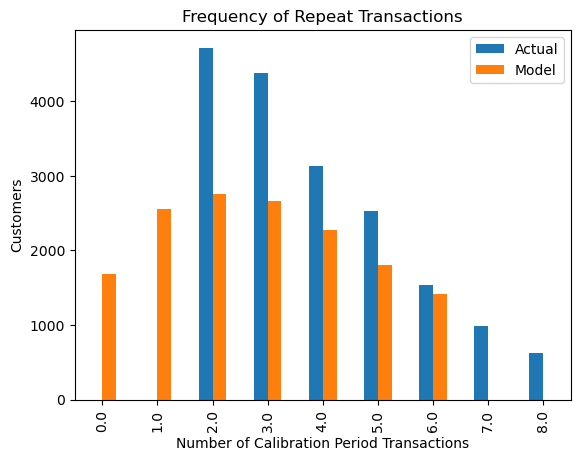

In [28]:
plot_period_transactions(bgf)
plt.show(block=True)

In [29]:
cltv_df["exp_sales_3_month"] = bgf.conditional_expected_number_of_purchases_up_to_time(12,
                                                        cltv_df['frequency'],
                                                        cltv_df['recency_cltv_weekly'],
                                                        cltv_df['T_weekly'])
cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.000,30.571,5.000,187.874,0.841
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.857,224.857,10.000,138.097,0.530
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.286,78.857,5.000,117.064,0.623
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.571,20.857,2.000,60.985,0.625
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.143,95.429,2.000,104.990,0.395


In [30]:
cltv_df["exp_sales_6_month"] = bgf.conditional_expected_number_of_purchases_up_to_time(24,
                                                        cltv_df['frequency'],
                                                        cltv_df['recency_cltv_weekly'],
                                                        cltv_df['T_weekly'])
cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.000,30.571,5.000,187.874,0.841,1.682
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.857,224.857,10.000,138.097,0.530,1.060
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.286,78.857,5.000,117.064,0.623,1.247
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.571,20.857,2.000,60.985,0.625,1.249
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.143,95.429,2.000,104.990,0.395,0.790


In [31]:
cltv_df.sort_values("exp_sales_3_month", ascending=False).head(10)


,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.714,13.000,12.000,155.917,1.660,3.321
10876,ae149d98-9b6a-11eb-9c47-000d3a38a36f,6.143,7.143,9.000,161.320,1.431,2.863
6812,ecd961cc-89fd-11eb-bf0a-000d3a38a36f,7.143,10.429,9.000,96.233,1.392,2.783
19725,b42b0244-1e8d-11eb-9dc3-000d3a38a36f,27.857,29.714,11.000,122.243,1.371,2.742
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,6.143,13.143,9.000,195.549,1.360,2.720
14122,bcc401de-73e8-11eb-b35d-000d3a38a36f,3.143,14.857,9.000,141.221,1.341,2.682
12157,492f9cf0-6e04-11ea-84a8-000d3a38a36f,19.714,20.857,9.000,207.889,1.279,2.557
10741,b35572aa-5f8e-11ea-be5b-000d3a38a36f,20.000,31.857,10.000,147.267,1.264,2.527
8328,1902bf80-0035-11eb-8341-000d3a38a36f,28.857,33.286,10.000,137.896,1.251,2.502
18997,41231c72-566a-11eb-9e65-000d3a38a36f,2.571,4.571,7.000,257.284,1.250,2.500


In [32]:
cltv_df.sort_values("exp_sales_6_month", ascending=False).head(10)

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.714,13.000,12.000,155.917,1.660,3.321
10876,ae149d98-9b6a-11eb-9c47-000d3a38a36f,6.143,7.143,9.000,161.320,1.431,2.863
6812,ecd961cc-89fd-11eb-bf0a-000d3a38a36f,7.143,10.429,9.000,96.233,1.392,2.783
19725,b42b0244-1e8d-11eb-9dc3-000d3a38a36f,27.857,29.714,11.000,122.243,1.371,2.742
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,6.143,13.143,9.000,195.549,1.360,2.720
14122,bcc401de-73e8-11eb-b35d-000d3a38a36f,3.143,14.857,9.000,141.221,1.341,2.682
12157,492f9cf0-6e04-11ea-84a8-000d3a38a36f,19.714,20.857,9.000,207.889,1.279,2.557
10741,b35572aa-5f8e-11ea-be5b-000d3a38a36f,20.000,31.857,10.000,147.267,1.264,2.527
8328,1902bf80-0035-11eb-8341-000d3a38a36f,28.857,33.286,10.000,137.896,1.251,2.502
18997,41231c72-566a-11eb-9e65-000d3a38a36f,2.571,4.571,7.000,257.284,1.250,2.500


### Gamma-Gamma Model
with this model we are going to calculate expected customer value in a specified time period

In [33]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

ggf.fit(cltv_df['frequency'], cltv_df['monetary_cltv_avg'])



<lifetimes.GammaGammaFitter: fitted with 19945 subjects, p: 4.16, q: 0.47, v: 4.09>

In [34]:
cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                             cltv_df['monetary_cltv_avg']) #per puchase
cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,expected_average_profit
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.000,30.571,5.000,187.874,0.841,1.682,193.602
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.857,224.857,10.000,138.097,0.530,1.060,140.285
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.286,78.857,5.000,117.064,0.623,1.247,120.949
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.571,20.857,2.000,60.985,0.625,1.249,67.296
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.143,95.429,2.000,104.990,0.395,0.790,114.280


### Customer life time value for 6 months

In [35]:
cltv_df["cltv"] = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency_cltv_weekly'],
                                   cltv_df['T_weekly'],
                                   cltv_df['monetary_cltv_avg'],
                                   time=6,
                                   freq="W",  # Frequency period ("Weeks")
                                   discount_rate=0.01)
cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,expected_average_profit,cltv
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.000,30.571,5.000,187.874,0.841,1.682,193.602,341.745
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.857,224.857,10.000,138.097,0.530,1.060,140.285,156.038
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.286,78.857,5.000,117.064,0.623,1.247,120.949,158.203
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.571,20.857,2.000,60.985,0.625,1.249,67.296,88.192
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.143,95.429,2.000,104.990,0.395,0.790,114.280,94.751


In [36]:
cltv_df["segment"] = pd.qcut(cltv_df["cltv"], 4, labels=["D", "C", "B", "A"])
cltv_df.sort_values("cltv", ascending = False).head(20)

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,expected_average_profit,cltv,segment
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8.286,9.429,2.000,650.245,0.686,1.371,696.450,1001.855,A
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.857,7.857,4.000,467.750,0.903,1.806,484.121,917.113,A
15123,635b5e0a-a686-11eb-a6d3-000d3a299ebf,2.000,5.143,3.000,447.110,0.818,1.636,468.268,803.832,A
10792,f1f89712-84e5-11eb-8a3c-000d3a38a36f,7.286,11.286,2.000,522.450,0.675,1.350,560.003,792.987,A
7173,8897f4a8-c793-11ea-b753-000d3a38a36f,40.143,45.714,3.000,597.143,0.602,1.203,624.923,788.825,A
7153,5a351e90-b984-11eb-a757-000d3a38a36f,0.000,1.714,2.000,451.985,0.734,1.468,484.768,746.568,A
8496,c1f0cd2c-8d51-11eb-8604-000d3a38a36f,0.000,9.714,3.000,430.270,0.786,1.572,450.684,743.495,A
14858,031b2954-6d28-11eb-99c4-000d3a38a36f,14.857,15.571,3.000,450.653,0.749,1.498,471.967,741.574,A
14833,b09765ae-29a1-11eb-b280-000d3a38a36f,1.571,27.857,2.000,552.810,0.592,1.184,592.419,736.244,A
4087,5ee23224-ad83-11ea-b736-000d3a38a36f,49.571,50.429,2.000,631.105,0.508,1.015,676.014,720.120,A


We can identify which customers have the highest revenue that is expected to bring the company, and give the info to sales and marketing departments.

In [37]:
cltv_df.groupby("segment").agg({"count", "mean", "sum"}).sort_values("segment",ascending=False)

recency_cltv_weekly                    T_weekly                    frequency                 monetary_cltv_avg                     exp_sales_3_month                exp_sales_6_month                expected_average_profit                      cltv                    
                      count        sum    mean    count        sum    mean     count       sum  mean             count         sum    mean             count      sum  mean             count      sum  mean                   count         sum    mean count         sum    mean
segment                                                                                                                                                                                                                                                                           
A                      4986 296977.286  59.562     4986 373649.286  74.940      4986 24848.000 4.984              4986 1090446.526 218.702              4986 3205.369 0.643              4986 6410.738 1.286                    4986 1138510.924 228.342  4986 1460455.092 292.911
B                      4986 408418.714  81.913     4986 500664.143 100.414      4986 23632.000 4.740              4986  790172.727 158.478              4986 2746.942 0.551              4986 5493.885 1.102                    4986  825773.781 165.618  4986  918393.966 184.195
C                      4986 502743.571 100.831     4986 601684.429 120.675      4986 21733.000 4.359              4986  633002.806 126.956              4986 2448.995 0.491              4986 4897.989 0.982                    4986  664306.570 133.234  4986  658120.512 131.994
D                      4987 691890.857 138.739     4987 807142.857 161.849      4987 18653.000 3.740              4987  460825.197  92.405              4987 2019.704 0.405              4987 4039.409 0.810                    4987  487820.114  97.818  4987  396704.279  79.548

For example in segment A, we expect to see 1,460,455 TL in 6 months. So company can decide its expenses for marketing or investmenst etc, according to these values. 

# Conclusion
In conclusion, RFM (Recency, Frequency, Monetary) and CLTV (Customer Lifetime Value) are two powerful methods that can help businesses better understand and analyze their customer base. By leveraging these methods, businesses can gain valuable insights into customer behavior, identify their most valuable customers, and make data-driven decisions to optimize their marketing and sales strategies.

In this Kaggle notebook, we explored how to calculate RFM and CLTV for FLO Retail and Marketing Inc.'s sales dataset using various data analysis and visualization techniques.

Overall, the RFM and CLTV methods can provide businesses with a holistic view of their customer base and help them improve customer retention, increase customer satisfaction, and ultimately drive revenue growth. By implementing these methods and regularly analyzing customer data, businesses can stay competitive in today's fast-paced and ever-changing business landscape.



Thank you for your suggestions and comments :)  
My linkedin profile: https://www.linkedin.com/in/sefercan-apaydin/  
My Github profile: https://github.com/sefercanapaydin  
References: https://www.miuul.com/  